# IPython Graphs 

## This notebook uses: Neo4j 2.1.6, Titan 0.9.0-M1(Berkeley DB) w/TP3 Gremlin Server 3.0.0-M7, ipython-cypher 0.2.1, projx 0.3.6(dev), Pandas 0.15.2, NetworkX 1.9, and gizmo 0.1.7(dev)

### This notebook is <em>NOT</em> meant to be a benchmark!!! It's just an example that plays around with some code that I've been working on using some libraries and DBs that I like.

In [1]:
%matplotlib inline
%load_ext cypher

In [2]:
import asyncio
import networkx as nx
import pandas as pd
import projx as px
import matplotlib.pyplot as plt
from datetime import datetime
from gizmo import AsyncGremlinClient

In [3]:
plt.rcParams['figure.figsize'] = 12, 7

#### Load a bipartite network stored as an edgelist into Neo4j with projx using a Cypher MERGE.

Fire up the Neo4j server first:

```bash
./neo4j-community-2.1.6/bin/neo4j console
```

In [4]:
# The arXiv cond-mat data set: http://konect.uni-koblenz.de/networks/opsahl-collaboration
arXiv_condmat_etl = {
    "extractor": {
        "edgelist": {
            "filename": "data/opsahl-collaboration/out.opsahl-collaboration",
            "delim": " ",
            "pattern": [
                {"node": {"alias": "n"}},
                {"edge": {}},
                {"node": {"alias": "m"}}
            ]
        }
    },
    "transformers": [
        {
            "edge": {
                "pattern": [
                    {"node": {"alias": "n", "label": "Author"}},
                    {"edge": {"label": "IN"}},
                    {"node": {"alias": "m", "label": "Paper"}}
                ]
            }
        }
    ],
    "loader": {
        "edgelist2neo4j": {
            "uri": "http://localhost:7474/db/data",
            "stmt_per_req": 500,
            "req_per_tx": 25,
            "indicies": [
                {"label": "Author", "attr": "UniqueId"},
                {"label": "Paper", "attr": "UniqueId"}
            ]
        }
    }
}

In [5]:
px.execute_etl(arXiv_condmat_etl)

Statements per request: 500
Requests per transactions: 25
Created index: CREATE INDEX ON :Author(UniqueId);
Created index: CREATE INDEX ON :Paper(UniqueId);
Load complete: merged 58500 edges in 0:00:28.459678


**Not bad!** ~2000 merged edges/sec

In [5]:
# This uses ipython-cypher by @versae.
num_rels = %cypher match (auth:Author)-[rels:IN]->(pap:Paper) return count(rels)
num_auths = %cypher match (auth:Author) return count(auth)
num_papers = %cypher match (pap:Paper) return count(pap)

1 rows affected.
1 rows affected.
1 rows affected.


In [6]:
print(num_rels, num_auths, num_papers)

+-------------+
| count(rels) |
+-------------+
|    58595    |
+-------------+ +-------------+
| count(auth) |
+-------------+
|    16726    |
+-------------+ +------------+
| count(pap) |
+------------+
|   22015    |
+------------+


#### Load the graph into memory for manipulation.

In [7]:
neo4j2nx_etl = {
    "extractor": {
        "neo4j": {
            "query": "match (n:Author)-[:IN]->(m:Paper) return n, m",
            "uri": "http://localhost:7474/db/data"
        }
    }, 
    "transformers": [
        {
            "node": {
                "pattern": [{"node": {"alias": "n", "unique": "UniqueId"}}],
                "set": [
                    {"key": "name", "value_lookup": "n.UniqueId"},
                    {"key": "type", "value": "Author"}
                ]
            },
        },
        {
            "node": {
                "pattern": [{"node": {"alias": "m", "unique": "UniqueId"}}],
                "set": [
                    {"key": "name", "value_lookup": "m.UniqueId"},
                    {"key": "type", "value": "Paper"}
                ]
            },
        },
        {
            "edge": {
                "pattern": [
                    {"node": {"alias": "n", "unique": "UniqueId"}}, 
                    {"edge": {}}, 
                    {"node": {"alias": "m", "unique": "UniqueId"}}
                ] 
            }
        }
    ], 
    "loader": {
        "neo4j2nx": {}
    }
}

In [8]:
graph = px.execute_etl(neo4j2nx_etl)

In [9]:
num_papers = len([n for n, k in graph.nodes(data=True) if k["type"] == "Paper"])
num_authors = len([n for n, k in graph.nodes(data=True) if k["type"] == "Author"])

In [10]:
# Everything seems to be in order.
print(len(graph.edges()), num_authors, num_papers)

58595 16726 22015


#### Project a one mode social network using Newman's method to calculate edge weight.

In [11]:
p = px.Projection(graph)

In [12]:
subgraph = p.execute("""
    match (a1:Author)-(p:Paper)-(a2:Author)
    project (a1)-(a2) method newman Paper
    delete p""")

In [13]:
print(len(subgraph.nodes()), len(subgraph.edges())) # ~500 authors that wrote a single paper solo.

16264 47594


In [14]:
eweight = pd.Series([a["weight"] for (s, t, a) in subgraph.edges(data=True)])
eweight.describe()

count    47594.000000
mean         0.571679
std          0.809551
min          0.058824
25%          0.174242
50%          0.333333
75%          0.500000
max         22.333333
dtype: float64

#### Plot degree distribution of projected network.

In [15]:
def prob_dist(itrbl):
    count = {}
    for i in itrbl:
        count.setdefault(i, 0)
        count[i] += 1
    return pd.Series(count)

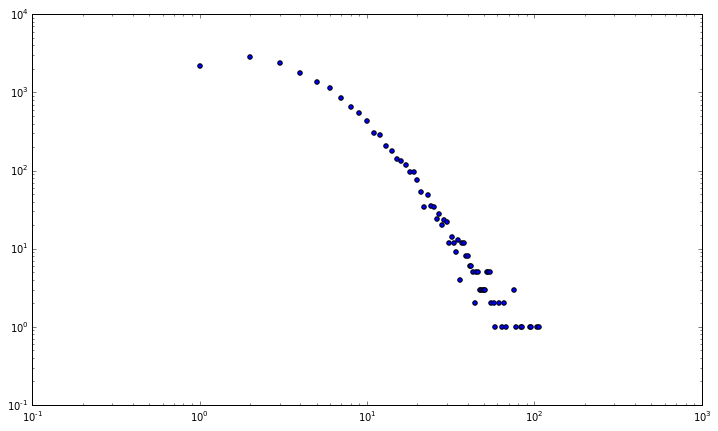

In [16]:
deg_dist = prob_dist(nx.degree(subgraph).values())
plt.scatter(deg_dist.index, deg_dist)
plt.xscale("log")
plt.yscale("log")

In [17]:
# Write to txtfile
with open('output.txt', 'w') as f:
    for s, t in subgraph.edges():
        f.write(str(s) + '\t' + str(t) + '\n')

#### Load the social network into Titan using the gizmo driver.

**Note:** This is just a quick demo to try out the driver, I've made no attempt to do any sort of batch loading/server tuning.

You can get the Titan 0.0.9 [here](https://groups.google.com/forum/#!msg/aureliusgraphs/_onvDrvBEwk/lHCNMqefzacJ). It comes packaged with the TP3 Gremlin Server, unpack and...

Fire up the Gremlin Server:

```bash
./bin/gremlin-server.sh 
```

In [18]:
def build_schema(gc):
    script = """
        mgmt = g.openManagement();
        uniqueId = mgmt.makePropertyKey('uniqueId').dataType(Integer.class).make();
        mgmt.buildIndex('byId', Vertex.class).addKey(uniqueId).unique().buildCompositeIndex();
        collabs=mgmt.makeEdgeLabel('collabs').make();
        mgmt.commit();"""
    task = gc.task(gc.submit, script,
        consumer=lambda x: print("Commited tx with response code: {}".format(x.status_code)))
    gc.run_until_complete(task)
    

def load_edges(gc):
    start = datetime.now()
    script = """     
        getOrCreate = { id ->
            def n = g.V().has('uniqueId', id)
            if (n.hasNext()) {n.next()} else {g.addVertex("uniqueId", id)}
        }

        new File('output.txt').eachLine {  
            (fromVertex, toVertex) = it.split('\t').collect(getOrCreate)
            fromVertex.addEdge('collabs', toVertex)
        }

        g.tx().commit()"""
    task = gc.task(gc.submit, script,
        consumer=lambda x: print("Commited tx with response code: {}".format(x.status_code)))
    gc.run_until_complete(task)
    print("Loaded in {}".format(datetime.now() - start))

    
@asyncio.coroutine
def count_nodes(gc):
    yield from gc.submit("g.V().count()", collect=False, consumer=lambda x: print(x))

    
@asyncio.coroutine
def count_edges(gc):
    yield from gc.submit("g.E().count()", collect=False, consumer=lambda x: print(x))

In [19]:
gc = AsyncGremlinClient()

In [20]:
build_schema(gc)

Commited tx with response code: 200


In [21]:
load_edges(gc)

Commited tx with response code: 200
Loaded in 0:00:16.713325


In [22]:
gc.run_until_complete(count_nodes(gc))

[16264]


In [23]:
gc.run_until_complete(count_edges(gc))

[47594]


####(I'm sure you can do that much faster with some config tricks, I'm not exactly a Gremlin expert either...)